In [7]:
using PyPlot
using PyCall
using Peaks
np=pyimport("numpy")
eV = 27.2114; #Hartree to eV conversion
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "small"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.titlesize"] = "xx-large"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"
rcParams["figure.figsize"] = (6, 6);

In [8]:
dir_nohybrid = string(pwd(), "/nohybrid");

In [9]:
#Loop over all simulations and store the band indices and oscillator strengths corresponding to the 
#relevant green and red transitions. 

AllValidPairsGreen = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Float64}}}}()
# Vector of tuples of the form: (ID, (lowerband, upperband, oscillator strength))

AllValidPairsRed = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Float64}}}}()
# Vector of tuples of the form: (ID, (lowerband, upperband, oscillator strength))

eigenvalsup = Float64[]
eigenvalsdn= Float64[]
momenta = ComplexF64[] #Note that the momentum matrix elements are complex though we only need their absolute values 
#in the end since we have no phase interfering terms. 

for (i, j) in Tuple.(CartesianIndices(rand(4, 5)))
    id="$(i)$(j)"
    try #The try catch block exists in case there are files that don't exist or we decided to disregard and got rid of 
        eigenvalsup = np.fromfile("STH2$(id).eigenvals")[1:48]*eV
        eigenvalsdn = np.fromfile("STH2$(id).eigenvals")[49:96]*eV
        momenta = np.reshape(abs.(np.fromfile("STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    catch
        continue
    end
    (permutedims(momenta, (1, 2, 4, 3)) ≈ conj(momenta)) || error("Momenta Do Not Satisfy Hermiticity Condition")
    ValidPairsUpGreen = Vector{Tuple{Integer, Integer, Float64}}() 
    for (i, e) in enumerate(eigenvalsup)
        for (j, eprime) in enumerate(eigenvalsup)
            i > 27 && continue #The 27th band corresponds to the highest lying "valence" band, we do not consider transitions amongst two conduction bands of course
            j > 27 && continue
            i < 10 && continue
            j < 10 && continue
            ((j, i) in [v[1:2] for v in ValidPairsUpGreen]) && continue
            2.1 < abs(e-eprime) < 2.3  || continue
            #Note that we must convert back from eV to hartree, so the denominator is divided by 27.2
            push!(ValidPairsUpGreen, (i, j, eV*2/3*sum((abs.(momenta[1, :, i, j])).^2)/abs(e-eprime) ))
        end
    end
    #Find pairs of bands that give us the range of eigenvalues we desire: 
    ValidPairsUpRed = Vector{Tuple{Integer, Integer, Float64}}() 
    for (i, e) in enumerate(eigenvalsup)
        for (j, eprime) in enumerate(eigenvalsup)
            i > 27 && continue 
            j > 27 && continue
            i < 10 && continue
            j < 10 && continue
            ((j, i) in [v[1:2] for v in ValidPairsUpRed]) && continue
            1.7 < abs(e-eprime) < 1.9  || continue
            push!(ValidPairsUpRed, (i, j, eV*2/3*sum((abs.(momenta[1, :, i, j])).^2)/abs(e-eprime)))
        end
    end
    push!(AllValidPairsGreen, (id, ValidPairsUpGreen))
    push!(AllValidPairsRed, (id, ValidPairsUpRed))

end

In [10]:
OscillatorStrengthsGreen = Float64[] #Vectors of the maximum oscillator strengths for the maximum oscillator strength transitions
OscillatorStrengthsRed = Float64[] #For the green and red transitions respectively

for (ValidPairsUpGreen, ValidPairsUpRed) in zip(AllValidPairsGreen, AllValidPairsRed)
    id = ValidPairsUpGreen[1]
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV

    maxgreen = argmax([v[3] for v in ValidPairsUpGreen[2]])
    maxred = argmax([v[3] for v in ValidPairsUpRed[2]])
    println(maxgreen, "  ", maxred)
    println("Max Green Oscillator Strength: ", [v[3] for v in ValidPairsUpGreen[2]][maxgreen])
    println("Max Red Oscillator Strength: ", [v[3] for v in ValidPairsUpRed[2]][maxred])
    
    push!(OscillatorStrengthsGreen, [v[3] for v in ValidPairsUpGreen[2]][maxgreen])
    push!(OscillatorStrengthsRed, [v[3] for v in ValidPairsUpRed[2]][maxred])

    greenplots = plot()

    for i in 1:48
#         (i == ValidPairsUpGreen[2][maxgreen][1]) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5, legend=false, size=(1000,400), xticks=Float64[]) : plot!(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4, legend=false, size=(500,400), xticks=Float64[]);
#         (i == ValidPairsUpGreen[2][maxgreen][2]) ? plot!(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="green", linewidth=5, legend=false, size=(1000,400), xticks=Float64[]) : plot!(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4, legend=false, size=(500,400), xticks=Float64[]);
    end
#     ylims!(-20, -10)
#     ylabel!("Energy (eV)", yguidefontsize=10, titlefontsize=10)
#     title!("Valid Pairs (shown in green) ID: $(id)")

    redplots=plot()
    for i in 1:48
#         (i == ValidPairsUpRed[2][maxred][1]) ? plot!(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5, legend=false, size=(500,400), xticks=Float64[]) : plot!(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4,  size=(500,400), xticks=Float64[]);
#         (i == ValidPairsUpRed[2][maxred][2]) ? plot!(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="red", linewidth=5, legend=false, size=(500,400), xticks=Float64[]) : plot!(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4,  size=(500, 400), xticks=Float64[]);
    end
#     ylims!(-20, -10)
    #ylabel!("Energy (eV)")
#     title!("Valid Pairs (shown in red) ID: $(id)", titlefontsize=10);    
    μ=0 
    for l in readlines("$dir_nohybrid/STH2$(id).eigStats")
        if VERSION.minor >= 5  
            contains(l, "mu" ) || continue ;
        elseif VERSION.minor < 5
            occursin("mu", l) || continue ;
        end
        μ = parse(Float64, l[6:end]);
    end
    FSTH2=zeros(100*30)
    energies = collect(range(0, 30, length=3000))
    lambdas = 1240 ./ collect(range(1, 30, length=3000))
    broadening=0.1
    for e1iter in 1:48
        for e2iter in 1:48
            eigup2 = eigenvalsup[e2iter]
            eigup1 = eigenvalsup[e1iter]
            eigdn2 = eigenvalsdn[e2iter]
            eigdn1 = eigenvalsdn[e1iter]
            ediffup = (eigup2-eigup1)
            ediffdn = (eigdn2-eigdn1)
            momentaup_squared = sum((abs.(momenta[1, :, e1iter, e2iter])).^2)
            momentadn_squared = sum((abs.(momenta[2, :, e1iter, e2iter])).^2)
            f = (1-np.heaviside(μ*eV-eigup2, 0.5))*(np.heaviside(μ*eV-eigup1, 0.5))
            !(f ≈ 0) && (f *= 2/3*(1/ediffup)*(momentaup_squared))
            FSTH2 += f*exp.(-0.5*(energies.-ediffup).^2/(broadening)^2)
            f = (1-np.heaviside(μ*eV-eigdn2, 0.5))*(np.heaviside(μ*eV-eigdn1, 0.5))
            !(f ≈ 0) && (f *= 2/3*(1/ediffdn)*(momentadn_squared))
            FSTH2 += f*exp.(-0.5*(energies.-ediffdn).^2/(broadening)^2)
        end
    end
    FSTH2 *= eV
#     plot(lambdas, FSTH2, xlims=[400, 800],  
#     xlabel="Excitation Wavelength (nm)", xguidefontsize=10, yticks=[], title="Excitation Spectrum of STH2", titlefontsize=10, linewidth=5, legend=false, size=(500, 500))
    #xlabel="Excitation Energy (eV)", xguidefontsize=20, yticks=[], title="Excitation Spectrum of STH2", titlefontsize=20, linewidth=5, legend=false, size=(1000, 500))
#     c=ylabel!("Oscillator Strength (A.U.)", yguidefontsize=10)
#     display(plot(greenplots, redplots, c, size=(1000, 500)))
end

In [11]:
figure(figsize=(20, 10))
for (ValidPairsGreen, ValidPairsRed) in zip(AllValidPairsGreen, AllValidPairsRed)
    id = ValidPairsGreen[1]
    # id "41" seems closest to experimentally reported spectrum
    id == "41" || continue
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
    momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    maxgreen = argmax([v[4] for v in ValidPairsGreen[2]])
    maxred = argmax([v[4] for v in ValidPairsRed[2]])

    println("Max Green Oscillator Strength: ", [v[4] for v in ValidPairsGreen[2]][maxgreen])
    println("Max Red Oscillator Strength: ", [v[4] for v in ValidPairsRed[2]][maxred])
    push!(OscillatorStrengthsGreen, [v[4] for v in ValidPairsGreen[2]][maxgreen])
    push!(OscillatorStrengthsRed, [v[4] for v in ValidPairsRed[2]][maxred])
    subplot(1, 2, 1)
    for i in 1:48
        ((i == ValidPairsGreen[2][maxgreen][2]) && (ValidPairsGreen[2][maxgreen][1] == 1))  ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][3]) && (ValidPairsGreen[2][maxgreen][1] == 1)) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="green", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][2]) && (ValidPairsGreen[2][maxgreen][1] == 2))  ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][3]) && (ValidPairsGreen[2][maxgreen][1] == 2)) ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="green", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
    end
    ylim(-20, -10)
    ylabel("Energy (eV)")
    subplot(1, 2, 2)
    for i in 1:48
        ((i == ValidPairsRed[2][maxred][2]) && (ValidPairsRed[2][maxred][1] == 1))  ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][3]) && (ValidPairsRed[2][maxred][1] == 1)) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="red", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][2]) && (ValidPairsRed[2][maxred][1] == 2))  ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][3]) && (ValidPairsRed[2][maxred][1] == 2)) ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="red", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
    end
    ylim(-20, -10)
end

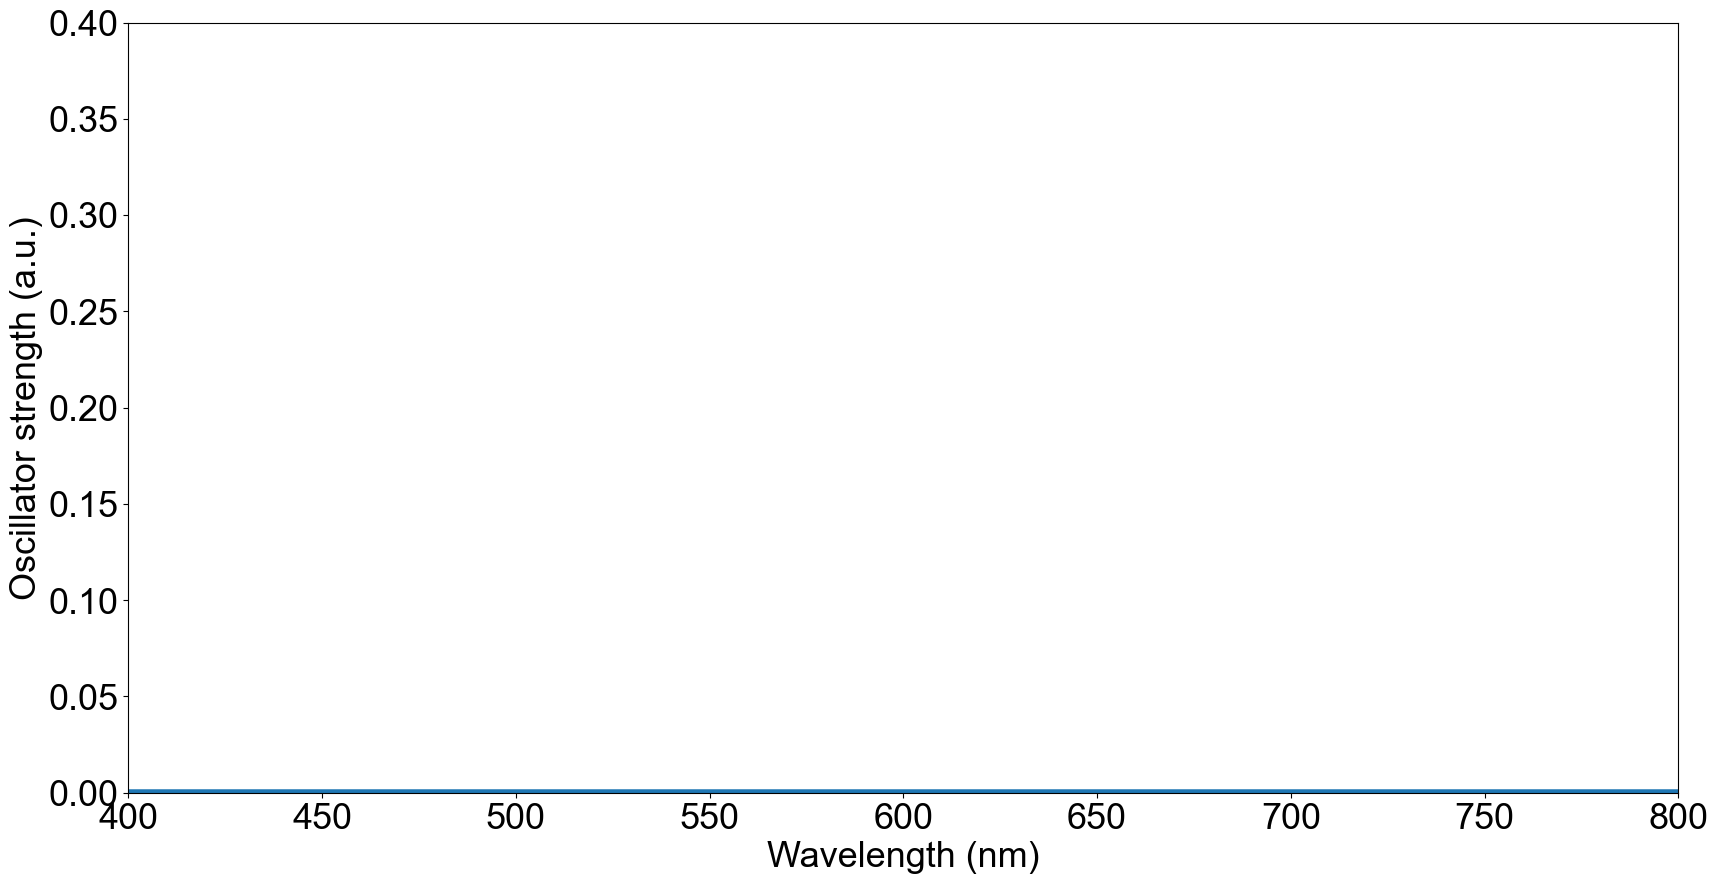

(0.0, 0.4)

In [12]:
figure(figsize=(20, 10))
OscillatorStrengthsGreen = Float64[] #Vectors of the maximum oscillator strengths for the maximum oscillator strength transitions
OscillatorStrengthsRed = Float64[] #For the green and red transitions respectively
FSTH2=zeros(100*30)
energies = collect(range(1, 30, length=3000))
lambdas = 1240 ./ collect(range(1, 30, length=3000))
broadening=0.2

for id in ["41"]
    for (ValidPairsGreen, ValidPairsRed) in zip(AllValidPairsGreen, AllValidPairsRed)
        ValidPairsGreen[1] == id || continue
        eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
        eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
        momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
        μ=0 
        for l in readlines("$dir_nohybrid/STH2$(id).eigStats")
            if VERSION.minor >= 5  
                contains(l, "mu" ) || continue ;
            elseif VERSION.minor < 5
                occursin("mu", l) || continue ;
            end
            μ = parse(Float64, l[6:end]);
        end
        for e1iter in 10:19
            for e2iter in 20:30
                e2iter > e1iter || continue
                eigup2 = eigenvalsup[e2iter]
                eigup1 = eigenvalsup[e1iter]
                eigdn2 = eigenvalsdn[e2iter]
                eigdn1 = eigenvalsdn[e1iter]

                ediffup = (eigup2-eigup1)
                ediffdn = (eigdn2-eigdn1)
                momentaup_squared = sum((abs.(momenta[1, :, e1iter, e2iter])).^2)
                momentadn_squared = sum((abs.(momenta[2, :, e1iter, e2iter])).^2)
                f = (1-np.heaviside(μ*eV-eigup2, 0.5))*(np.heaviside(μ*eV-eigup1, 0.5))
                f *= 2/3*(1/ediffup)*(momentaup_squared)
                FSTH2 += f*exp.(-0.5*(energies.-ediffup).^2/(broadening)^2)
                f = (1-np.heaviside(μ*eV-eigdn2, 0.5))*(np.heaviside(μ*eV-eigdn1, 0.5))
                f *= 2/3*(1/ediffdn)*(momentadn_squared)
                FSTH2 += f*exp.(-0.5*(energies.-ediffdn).^2/(broadening)^2)
            end
        end
    end
end
FSTH2 *= eV
plot(lambdas, FSTH2, linewidth=5)
ylabel("Oscillator strength (a.u.)")
xlabel("Wavelength (nm)")
xlim(400,800)
ylim(0, 0.4)